# Spiking Data Processing and Analysis

ในบทเรียนนี้เราจะมาดูกันว่า จาก raw data หน้าตายุ่งๆ จะนำไปสู่ raster plot, tuning curve, และ data analysis ลักษณะอื่นๆ เพื่อทำความเข้าใจการทำงานของนิวรอนได้อย่างไร

บทเรียนนี้อ้างอิงจากเนื้อหา Brain Building Blocks session 3-4 หัวข้อ [Single Neuron Studies](https://www.youtube.com/watch?v=j4_m8PE0zcs&list=UULFq6dNW5GdYGggpt-UHavt0w&index=35) และ [From firings to meanings](https://www.youtube.com/watch?v=49ZKOzhMsW0&list=UULFq6dNW5GdYGggpt-UHavt0w&index=31)

# Pre-processing




**Pre-processing**
ข้อมูลดิบ (raw data) ที่ได้จากการวัดสัญญาณประสาทด้วยขั้วไฟฟ้า (electrode) จะมีลักษณะเป็น time-series data ที่ประกอบไปด้วย action potentials หรือ spikes ที่มีลักษณะเป็นเข็มแหลมๆ (high-frequency component) อยู่บนคลื่นเตี้ยๆ (low-frequency component) ดังภาพประกอบแถวที่ 2

**Filtering**
ซึ่งหากนำ raw data มาผ่าน low-pass filter จะได้ Local Field Potential (ภาพประกอบแถวที่ 1; เป็น time-series data ที่สามารถนำไปวิเคราะห์ต่อได้ สามารถศึกษาเพิ่มเติมได้ที่ https://www.youtube.com/watch?v=PwkYgrTE2fU)

และหากนำ raw data เดียวกันมาผ่าน high-pass filter จะได้ Multi-unit activities (spikes บนพื้นเรียบ ดังภาพประกอบแถวล่างสุด)

**Spike Detection/Thresholding**
จากนั้นจะเห็นได้ว่า เราสามารถตั้ง threshold บน Multi-unit activities เพื่อ detect spikes ได้ง่ายขึ้น (ลองจินตนาการดูว่าหากไม่ filter ก่อนแล้วตั้ง threshold เลย spike detection จะเป็นอย่างไร)

**Spike Sorting/Clustering**
เนื่องจากสัญญาณที่ electrode บันทึกได้ มักเป็นสัญญาณที่มาจากหลายนิวรอนรอบๆ electrode นั้น (เห็นได้จาก waveforms ที่มีลักษณะต่างกันดังแสดงด้วย 4 สีที่แตกต่างกัน ดังภาพประกอบแถวที่ 3)
ในกรณีที่นักวิจัยต้องการสัญญาณจากเซลล์เดี่ยว (single-unit) ขั้นตอน Spike sorting ด้วยการแยกตาม features ต่างๆ ของ  waveforms จะช่วยให้สามารถแยกสัญญาณจากแต่ละเซลล์ สำหรับการวิเคราะห์พฤติกรรมของนิวรอนแบบเดี่ยวๆ ต่อไป เช่น tuning curve, tuning progression plot, etc.

ในหลายกรณี นักวิจัยสามารถ decode สัญญาณประสาทจากหลายเซลล์ (multi-unit) ซึ่งไม่จำเป็นต้องแยกสัญญาณเซลล์เดี่ยว ทำให้สามารถข้ามขั้นตอน spike sorting ไปได้

เนื่องจากโดยทั่วไป pre-processing ต้องใช้เวลามากโดยเฉพาะอย่างยิ่ง ในส่วนของ spike-sorting นอกจากนี้ raw data เป็นไฟล์ข้อมูลขนาดใหญ่เพราะใช้ sampling frequency ในการบันทึกข้อมูลค่อนข้างสูง
นักวิจัยส่วนใหญ่มักจะแชร์ pre-processed data ในรูปแบบของ spike timestamps หรือ spike trains (ตำแหน่งของสามเหลี่ยมเล็กๆ บนภาพแถวล่างสุด) พร้อมกับข้อมูลของ events และ conditions ต่างๆ ในการทดลองนั้นๆ

ดังนั้น ในบทเรียนนี้เราจะเริ่มจากการใช้ข้อมูลในรูปแบบ spike timestamps

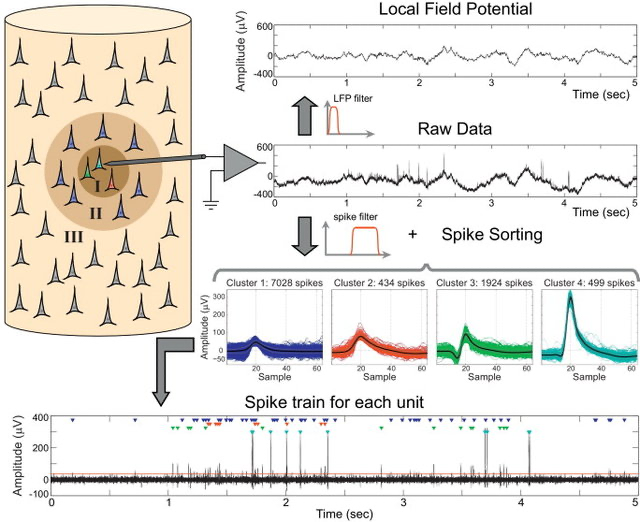

ที่มา: https://www.sciencedirect.com/science/article/pii/S0361923015000684?via%3Dihub


# Set Up

## Download ข้อมูลทั้งหมด
1. `single_unit_spikes.csv` เป็นไฟล์ที่เก็บ spike timestamps สำหรับสร้าง raster plot เพื่อ visualize ข้อมูล และสร้าง tuning curve
2. `single_unit_spikes_density.csv` เป็นไฟล์ที่เก็บ spike density function ที่ผ่านการนำ spiking data มา convolve กับ gausian function ให้เป็น firing rate สำหรับ visualize data ในแกนเวลา
3. `multi_unit_spiking_density.csv` เป็นไฟล์ multi-unit data

In [1]:
!git clone https://github.com/braincodecamp/modality-exploration-spiking-data.git
!mv modality-exploration-spiking-data/* .
!rm -r modality-exploration-spiking-data

Cloning into 'modality-exploration-spiking-data'...
remote: Enumerating objects: 10, done.
remote: Total 10 (delta 0), reused 0 (delta 0), pack-reused 10 (from 1)
Receiving objects: 100% (10/10), 148.91 MiB | 17.67 MiB/s, done.
Updating files: 100% (7/7), done.


## Import modules

In [2]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import scipy
from sklearn.decomposition import PCA
import ipywidgets as widgets  # ใช้สำหรับการทำ interactive display

# Single-Unit Analyses:

In [3]:
singleUnit_spikeTimestamps = pd.read_csv('data/single_unit_spikes.csv')
print(singleUnit_spikeTimestamps.head())

                        unit_name analysisEpoch  spikeTimes_1  spikeTimes_2  \
0  MrCassius-190328_D2_AC_R2_u021        stimOn           NaN           NaN   
1  MrCassius-190328_D2_AC_R2_u021        stimOn           NaN           NaN   
2  MrCassius-190328_D2_AC_R2_u021        stimOn           NaN           NaN   
3  MrCassius-190328_D2_AC_R2_u021        stimOn           NaN           NaN   
4  MrCassius-190328_D2_AC_R2_u021        stimOn           NaN           NaN   

   spikeTimes_3  spikeTimes_4  spikeTimes_5  nSpikes  firingRate  trial_index  \
0           NaN           NaN           NaN        0         0.0            1   
1           NaN           NaN           NaN        0         0.0            2   
2           NaN           NaN           NaN        0         0.0            3   
3           NaN           NaN           NaN        0         0.0            4   
4           NaN           NaN           NaN        0         0.0            5   

      stmFreq  stmFreqIndx  timewin_s 

## Raster plot


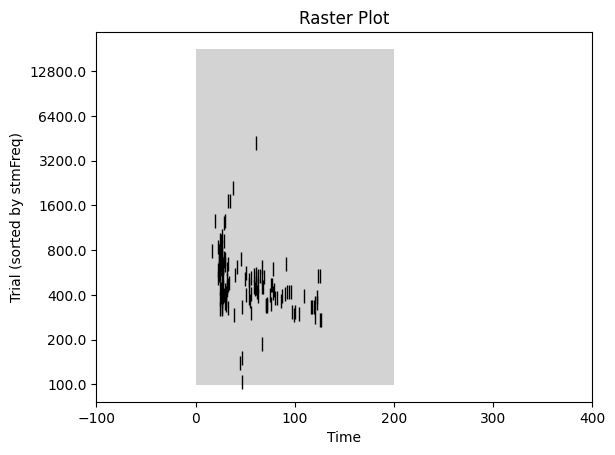

In [4]:
import matplotlib.patches as patches

# Sort trials by stmFreq
sorted_df = singleUnit_spikeTimestamps.sort_values('stmFreq')

# Create a figure and axes
fig, ax = plt.subplots()

# Extract unique stmFreq values
unique_freqs = sorted_df['stmFreq'].unique()

# Find the number of spikeTimes columns
spike_cols = [col for col in sorted_df.columns if col.startswith('spikeTimes_')]
num_spike_cols = len(spike_cols)


# Plot raster (all in blue)
for i, trial in enumerate(sorted_df.index):
    for n in range(1, num_spike_cols + 1):
        col = f'spikeTimes_{n}'
        spike_times = sorted_df.loc[trial, col]
        if not pd.isna(spike_times):
            if isinstance(spike_times, (list, tuple, np.ndarray)):
                ax.plot(spike_times, [i] * len(spike_times), '|', markersize=10, color='black')  # Mark in black
            else:
                ax.plot(spike_times, i, '|', markersize=10, color='black')  # Mark in black

# Add grey box for 0-200 ms
rect = patches.Rectangle((0, -0.5), 200, len(sorted_df) + 0.5, linewidth=1, edgecolor='none', facecolor='lightgrey')
ax.add_patch(rect)

# Create a mapping from y-tick values to rounded stmFreq values
y_tick_mapping = {i * 10: round(freq, 0)
                  for i, freq in enumerate(unique_freqs)}

# Set y-ticks and labels (every 50)
y_ticks = range(0, 301, 40)
y_tick_labels = [y_tick_mapping.get(y, '') for y in y_ticks]
ax.set_yticks(y_ticks)
ax.set_yticklabels(y_tick_labels)

# Set x-axis limits
ax.set_xlim(-100, 400)

# Set labels
ax.set_xlabel('Time')
ax.set_ylabel('Trial (sorted by stmFreq)')
ax.set_title('Raster Plot')

# Display the plot
plt.show()

## Tuning curve

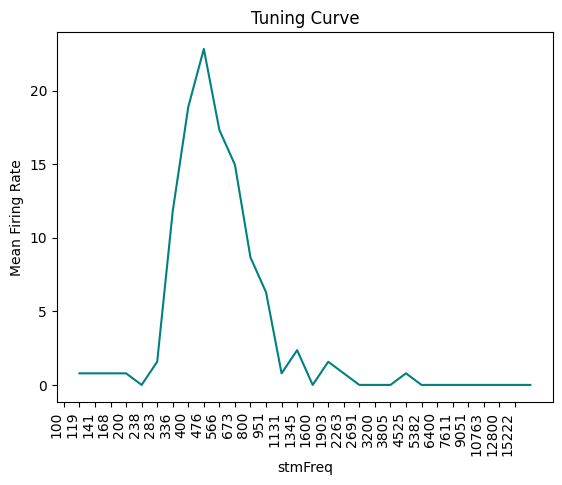

In [5]:
# Calculate mean firing rates for each stmFreq
mean_firing_rates = singleUnit_spikeTimestamps.groupby('stmFreqIndx')['firingRate'].mean()

# Sort by stmFreq
mean_firing_rates = mean_firing_rates.sort_index()

# Extract unique stmFreq values
unique_labels = singleUnit_spikeTimestamps.stmFreq.unique()
rounded_labels = [round(freq) for freq in unique_labels]  # Round unique labels
rounded_labels.sort()  # Sort rounded labels


# Create a figure and axes
fig, ax = plt.subplots()

# Plot tuning curve
ax.plot(mean_firing_rates.index, mean_firing_rates.values, color='teal')  # Use a teal color

# Set x-tick labels using rounded stmFreq values and equally spaced locations
ax.set_xticks(range(len(unique_labels)))
ax.set_xticklabels(rounded_labels, rotation=90, ha='right')  # Rotate labels 90 degrees

# Set labels
ax.set_xlabel('stmFreq')
ax.set_ylabel('Mean Firing Rate')
ax.set_title('Tuning Curve')

# Display the plot
plt.show()

# Population Analyses: Multi-Unit Data

## Load data

In [6]:
# Load and combine multi-unit spiking data files into a single dataframe
pattern = re.compile(r"multi_unit_spiking_density_part.*")
multi_unit_file_name_list = []
for curr_file in os.listdir('data'):
    if pattern.match(curr_file):
        multi_unit_file_name_list.append(curr_file)

multi_unit_file_name_list = np.sort(multi_unit_file_name_list)

for idx, curr_file in enumerate(multi_unit_file_name_list):
    curr_df = pd.read_csv(os.path.join('data', curr_file))
    if idx == 0:
      multi_unit_data_df = curr_df
    else:
      multi_unit_data_df = pd.concat((multi_unit_data_df, curr_df), axis=0)

# Print out some information about our data
print(f"The shape of the dataframe = {multi_unit_data_df.shape}")
print(f"Column names: {multi_unit_data_df.columns}")

# Display 10 random rows of the data
multi_unit_data_df.sample(10)

The shape of the dataframe = (38040, 1005)
Column names: Index(['Unnamed: 0', 'dataset_name', 'stmFreq', 'mean_spikeDensity_1',
       'mean_spikeDensity_2', 'mean_spikeDensity_3', 'mean_spikeDensity_4',
       'mean_spikeDensity_5', 'mean_spikeDensity_6', 'mean_spikeDensity_7',
       ...
       'timeBin_492', 'timeBin_493', 'timeBin_494', 'timeBin_495',
       'timeBin_496', 'timeBin_497', 'timeBin_498', 'timeBin_499',
       'timeBin_500', 'timeBin_501'],
      dtype='object', length=1005)


,Unnamed: 0,dataset_name,stmFreq,mean_spikeDensity_1,mean_spikeDensity_2,mean_spikeDensity_3,mean_spikeDensity_4,mean_spikeDensity_5,mean_spikeDensity_6,mean_spikeDensity_7,...,timeBin_492,timeBin_493,timeBin_494,timeBin_495,timeBin_496,timeBin_497,timeBin_498,timeBin_499,timeBin_500,timeBin_501
1517,1517,MrC_190328_153519_PT_D2_AC_ch06_mu,1902.731384,51.941137,51.196987,50.450069,49.702489,48.957693,48.216141,47.482921,...,391,392,393,394,395,396,397,398,399,400
3764,22784,MrC_190924_151318_PT_D4_AC_ch01_mu,1131.370850,7.218200,7.283607,7.363150,7.456370,7.562724,7.681594,7.812296,...,391,392,393,394,395,396,397,398,399,400
5602,15112,MrC_190705_181401_PT_D3_AC_ch07_mu,4525.483400,122.761540,122.570936,122.420210,122.309225,122.237700,122.204576,122.208384,...,391,392,393,394,395,396,397,398,399,400
6912,25932,MrM_190417_140301_PT_D2_AC_ch09_mu,800.000000,3.076226,3.043898,3.019524,3.002515,2.992265,2.988161,2.989588,...,391,392,393,394,395,396,397,398,399,400
4948,23968,MrM_190415_131533_PT_D2_AC_ch24_mu,12800.000000,0.387133,0.401584,0.420555,0.444810,0.473259,0.506550,0.544788,...,391,392,393,394,395,396,397,398,399,400
1728,11238,MrC_190526_141031_PT_D3_AC_ch03_mu,2262.741700,19.386261,19.670551,19.947185,20.215207,20.473668,20.721621,20.958139,...,391,392,393,394,395,396,397,398,399,400
2789,2789,MrC_190330_162647_PT_D2_AC_ch05_mu,15221.851072,42.319776,42.566868,42.799969,43.017603,43.221390,43.408696,43.581059,...,391,392,393,394,395,396,397,398,399,400
3406,31936,MrM_190530_210459_PT_D3_AC_ch13_mu,1600.000000,7.110674,7.244230,7.375881,7.504853,7.630418,7.752577,7.869532,...,391,392,393,394,395,396,397,398,399,400
7937,36467,MrM_190823_151625_PT_D3_AC_ch10_mu,1902.731384,14.798203,15.046170,15.290481,15.529704,15.762343,15.986841,16.202275,...,391,392,393,394,395,396,397,398,399,400
2035,11545,MrC_190531_133718_PT_D3_AC_ch23_mu,7610.925536,5.931582,5.798012,5.662630,5.525437,5.386457,5.245738,5.103474,...,391,392,393,394,395,396,397,398,399,400


Extract information from the dataframe

In [7]:
# Create a list of column names that can be used to extract 'timeBin' from the dataframe
time_bin_col_list = []

# Create a list of column names that can be used to extract 'mean_spike_density_col_list' from the dataframe
mean_spike_density_col_list = []

for col_name in multi_unit_data_df.columns:
    if col_name.startswith('timeBin_'):
        time_bin_col_list.append(col_name)
    if col_name.startswith('mean_spikeDensity_'):
        mean_spike_density_col_list.append(col_name)

# Check the number of time bins and the number of mean spike densities
num_time_bins = len(time_bin_col_list)
num_mean_spike_density = len(mean_spike_density_col_list)

# Check if we have the same number of time bins and mean spike densities
if num_time_bins != num_mean_spike_density:
    raise ValueError("num_time_bins must equal num_mean_spike_density")
print(f"There are {num_time_bins} time bins")
print(f"There are {num_mean_spike_density} mean spike density")

# Extract the list of frequencies
stim_freq_list = np.unique(multi_unit_data_df['stmFreq'])
num_stim_freqs = len(stim_freq_list)
print(f"There are {num_stim_freqs} unique stim frequencies")

# Extract the list of units
unit_list = np.unique(multi_unit_data_df['dataset_name'])
num_units = len(unit_list)
print(f"There are {num_units} different units")

There are 501 time bins
There are 501 mean spike density
There are 30 unique stim frequencies
There are 1268 different units


## Apply PCA

We will create a feature matrix

In [8]:
for idx, curr_stim_freq in enumerate(stim_freq_list):

    # Extract data with a specific stim frequency for all time points: num_units x num_time_points
    temp = multi_unit_data_df[multi_unit_data_df['stmFreq'] == curr_stim_freq][mean_spike_density_col_list]

    # Transpose the matrix such that the mean spike density from each unit becomes a feature: num_time_points x num_units
    curr_features = temp.transpose().values
    curr_labels_stim_freq = curr_stim_freq*np.ones((curr_features.shape[0],))
    curr_labels_time = np.arange(1, num_time_bins+1)

    # Combine data from different stim frequencies
    if idx == 0:
        features = curr_features
        labels_stim_freq = curr_labels_stim_freq
        labels_time = curr_labels_time
    else:
        features = np.concatenate((features, curr_features), axis=0)
        labels_stim_freq = np.concatenate((labels_stim_freq, curr_labels_stim_freq), axis=0)
        labels_time = np.concatenate((labels_time, curr_labels_time), axis=0)

print(f"Our feature matrix should have {num_time_bins*num_stim_freqs} rows and {num_units} columns")
print(f"Our feature matrix actually has {features.shape[0]} rows and {features.shape[1]} columns")

# Check if we have the same number of time bins and mean spike densities
if (features.shape[0] != num_time_bins*num_stim_freqs) or (features.shape[1] != num_units):
    raise ValueError("num_time_bins must equal num_mean_spike_density")

Our feature matrix should have 15030 rows and 1268 columns
Our feature matrix actually has 15030 rows and 1268 columns


Generate the data matrix by using the mean spike density from all units at a specific time point as our features

<br>

The mean spike density for a specific stimulus frequency and a specific time bin is treated as one sample with `num_units` features

In [9]:
# ลองลดมิติโดยใช้ PCA
n_components = 2
model_pca = PCA(n_components=n_components, whiten=True, random_state=777)
features_pca = model_pca.fit_transform(features)

# Print ดู variance ที่อธิบายด้วย principal components 3 ตัวแรก
print(f"% variance captured by PC1 = {model_pca.explained_variance_ratio_[0]*100: 0.2f}")
print(f"% variance captured by PC2 = {model_pca.explained_variance_ratio_[1]*100: 0.2f}")

% variance captured by PC1 =  36.89
% variance captured by PC2 =  9.99


Plot the results using
- different colors for different stim frequencies
- different alpha values for different time points (from totally transparent at time bin 1 to totally opaque at the last time bin

In [10]:
print(f"Stimulus frequency list: {stim_freq_list}")

Stimulus frequency list: [  100.           118.9207115    141.42135624   168.17928305
   200.           237.841423     282.84271247   336.3585661
   400.           475.682846     565.68542495   672.7171322
   800.           951.365692    1131.3708499   1345.43426441
  1600.          1902.731384    2262.7416998   2690.86852881
  3200.          3805.46276801  4525.48339959  5381.73705762
  6400.          7610.92553602  9050.96679919 10763.47411525
 12800.         15221.85107203]


เตรียม color list สำหรับ plot

In [11]:
def get_equally_spaced_rainbow_colors(n):

    # Get the rainbow colormap
    cmap = matplotlib.colormaps['rainbow']

    # Generate equally spaced indices within the colormap
    indices = np.linspace(0, cmap.N - 1, n, dtype=int)

    # Extract colors from the colormap
    color_list = [cmap(index)[:3] for index in indices]

    return color_list

display_color_list = get_equally_spaced_rainbow_colors(num_stim_freqs)

freq2display_color_dict = dict(zip(stim_freq_list, display_color_list))
custom_cmap = plt.cm.colors.ListedColormap([freq2display_color_dict[freq] for freq in freq2display_color_dict])

### Plot the PC scores for all stimulus frequencies and time bins

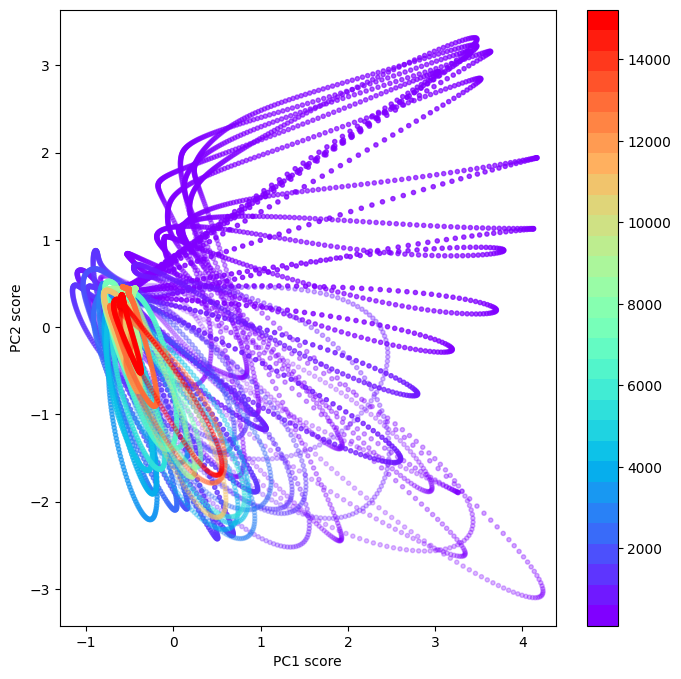

In [12]:
plt.figure(figsize=(8,8))
plt.scatter(features_pca[:,0],
            features_pca[:,1],
            c=labels_stim_freq,
            cmap=custom_cmap,
            marker='.',
            alpha=1-labels_time/np.max(labels_time)) # plot สีจาง ๆ สำหรับ time bin แรก แล้วไล่ให้เข้มขึ้นเรื่อย ๆ สำหรับ time bin ถัด ๆ ไป
plt.gca().set_aspect('equal', 'datalim')
plt.xlabel('PC1 score')
plt.ylabel('PC2 score')
plt.colorbar()
plt.show()

### Plot the principal components over time

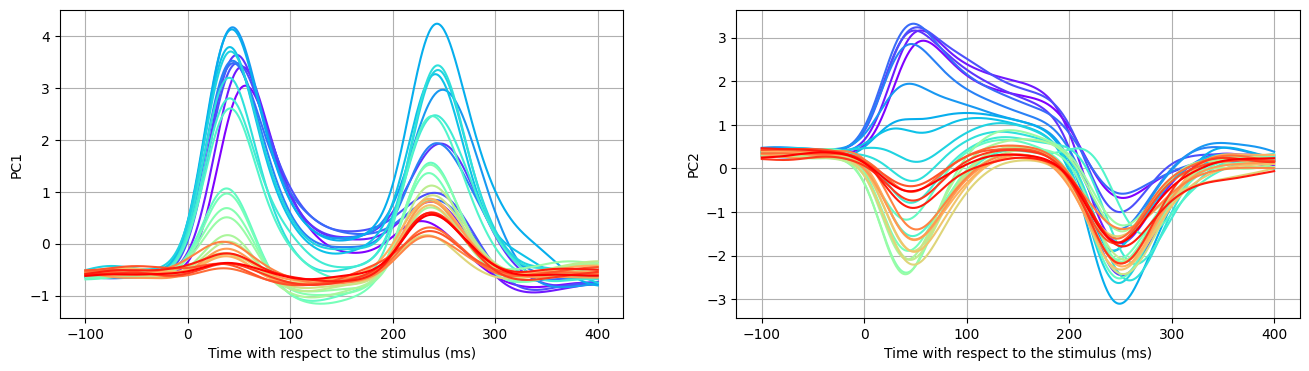

In [13]:
time_axis = multi_unit_data_df[time_bin_col_list].iloc[0,:].values
time2time_bin_dict = dict(zip(time_axis, np.arange(1, time_axis.shape[0]+1)))
time_bin2time_dict = dict(zip(np.arange(1, time_axis.shape[0]+1), time_axis))

fig, ax = plt.subplots(1, 2, figsize=(16, 4))

for idx_stim_freq, curr_stim_freq in enumerate(stim_freq_list):
    row_indices = (labels_stim_freq == curr_stim_freq)

    # Display PC1 over time for a specific stim freq
    ax[0].plot(time_axis,
               features_pca[row_indices,0],
               c=freq2display_color_dict[curr_stim_freq], label=curr_stim_freq)
    ax[0].set(xlabel='Time with respect to the stimulus (ms)', ylabel='PC1')
    ax[0].grid(True)

    ax[1].plot(time_axis,
               features_pca[row_indices,1],
               c=freq2display_color_dict[curr_stim_freq], label=curr_stim_freq)
    ax[1].set(xlabel='Time with respect to the stimulus (ms)', ylabel='PC2')
    ax[1].grid(True)

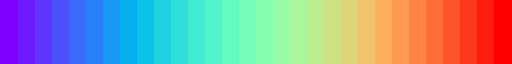

In [14]:
custom_cmap

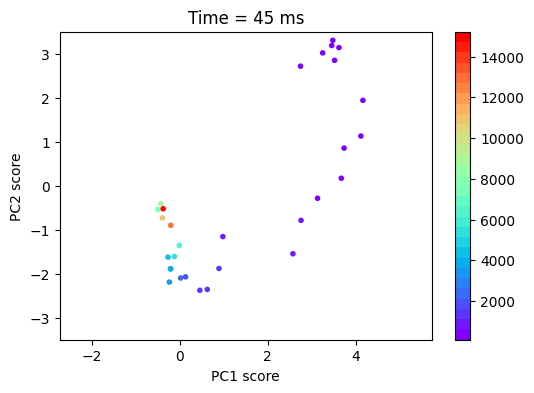

In [15]:
target_time_axis_ms = 45

features_pca_specific_time_bin = features_pca[labels_time == time2time_bin_dict[target_time_axis_ms]]
labels_stim_freq_specific_time_bin = labels_stim_freq[labels_time == time2time_bin_dict[target_time_axis_ms]]

plt.figure(figsize=(6,4))
plt.scatter(features_pca_specific_time_bin[:,0],
            features_pca_specific_time_bin[:,1],
            c=labels_stim_freq_specific_time_bin,
            cmap=custom_cmap,
            marker='.')
plt.gca().set_aspect('equal', 'datalim')
plt.title(f"Time = {target_time_axis_ms} ms")
plt.xlabel('PC1 score')
plt.ylabel('PC2 score')
plt.xlim((-1.2,4.2))
plt.ylim((-3.5,3.5))
plt.colorbar()
plt.show()

### Invesitgate interactive plot where you can change the time axis (ms) and see the PC results

In [16]:
@widgets.interact(target_time_axis_ms=widgets.IntSlider(value=45, min=time_axis[0], max=time_axis[-1]))
def plot_pc_result_specific_stim_freq(target_time_axis_ms):
    features_pca_specific_time_bin = features_pca[labels_time == time2time_bin_dict[target_time_axis_ms]]
    labels_stim_freq_specific_time_bin = labels_stim_freq[labels_time == time2time_bin_dict[target_time_axis_ms]]

    plt.figure(figsize=(6,4))
    plt.scatter(features_pca_specific_time_bin[:,0],
                features_pca_specific_time_bin[:,1],
                c=labels_stim_freq_specific_time_bin,
                cmap=custom_cmap,
                marker='.')
    plt.gca().set_aspect('equal', 'datalim')
    plt.title(f"Time = {target_time_axis_ms} ms")
    plt.xlabel('PC1 score')
    plt.ylabel('PC2 score')
    plt.xlim((-1.2,4.2))
    plt.ylim((-3.5,3.5))
    plt.colorbar()
    plt.show()


interactive(children=(IntSlider(value=45, description='target_time_axis_ms', max=400, min=-100), Output()), _d…

สำหรับผู้ที่สนใจศึกษาการวิเคราะห์ข้อมูล spiking activities แบบละเอียด (ตั้งแต่ pre-processing จนถึง analysese) สามารถศึกษาเพิ่มเติมได้ที่ https://www.youtube.com/watch?v=8xeC5CV4UB8&list=PL05umP7R6ij3SxudmSWFL_zGh0BMrRdrx&index=1

# ผู้จัดทำ

**ผู้จัดทำบทเรียน** ดร.ลลิตตา สุริยาอรุณโรจน์

**ผู้ตรวจสอบบทเรียน** ดร. อิทธิ ฉัตรนันทเวช